In [106]:
import parametrization as param
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection import generating_moments
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d, interp2d
import seaborn as sns
from CentralStreamingModel.moments import moments2model, read
from scipy.interpolate import UnivariateSpline
from halotools.mock_observables import tpcf_multipole
from scipy.optimize import curve_fit
import taylor_tools as tt
sns.set_context('talk')

In [11]:
n_boxes = 5
boxsize = 1024
snapshot = 0
rm = read.Read_Mean(n_boxes, boxsize, snapshot)

In [12]:
parameters = [r'$m_r$',r'$c_r$',r'$c_t$',r'$\xi$']

In [13]:
ex = generating_moments.Expectations(rm.r, rm.v_r, rm.v_t,
                                     rm.jointpdf_rt)


In [14]:
s = np.arange(0.,50.,1)
mu = np.linspace(0.,1,60)


In [15]:
moments_projected = generating_moments.project(ex, rm.r_perp,
                                    rm.r_parallel)

In [16]:
gaussian = moments2model.Model(rm, moments_projected, model='gaussian')


In [17]:
gaussian.multipoles(s, mu) 

In [18]:
m_r = ex.moment(1,0)(rm.r)
c_r = ex.central_moment(2,0)(rm.r)
c_t = ex.central_moment(0,2)(rm.r)

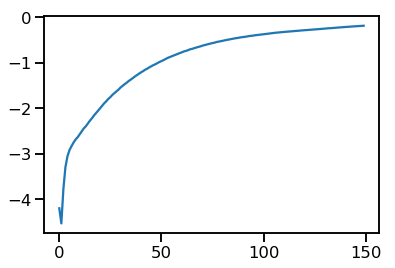

In [19]:
plt.plot(m_r, label='radial')


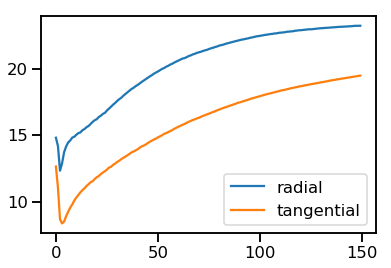

In [20]:
plt.plot(c_r, label='radial')
plt.plot(c_t, label='tangential')
plt.legend()

## FIT THE LOWEST THREE MOMENTS

In [21]:
def fitting_m_r(r, a,c,d):
    return a * r**(0.5) + c*r + d

0.11102734537588807


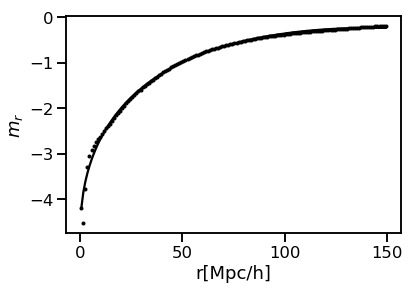

In [22]:
idx = 0

_, chi, popt_m_r = param.plot(fitting_m_r, rm.r, m_r, 
        'black', 'Halos',parameters[idx], limit = 20)
#plt.text(40, -2, r'$\chi^2_\nu $ = %.2f'%chi, fontdict=dict(color='black'))
#plt.text(40,-2,r'$m_r(r) = A \sqrt{r} + B r + C$')

In [23]:
def fitting_c(r, a, b,c):
    return a * r**b  + c

2.314160745363169


(6, 25)

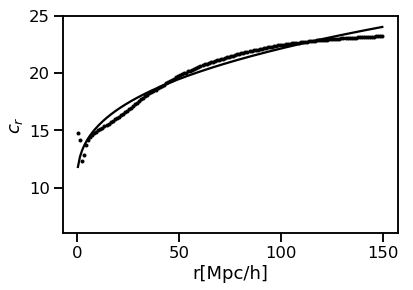

In [24]:
idx = 1

_, chi, popt_c_r = param.plot(fitting_c, rm.r, c_r, 
        'black', 'Halos',parameters[idx], limit = 0)
#plt.text(40,5,r'$c_r(r) = A r^B + C$')

plt.ylim(6,25)

3.8706306673543964


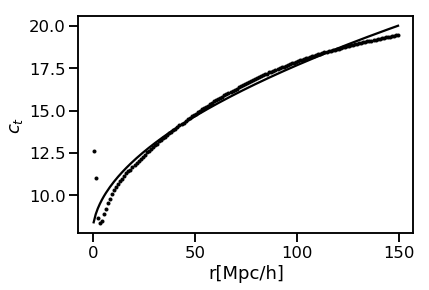

In [25]:
idx = 2

_, chi, popt_c_t = param.plot(fitting_c, rm.r, c_t, 
        'black', 'Halos',parameters[idx], limit = 0)
#plt.text(10,15,r'$c_t(r) = A r^B + C$')


In [26]:
def fitting_xi(r, a, b):
    return (r/a)**(-b) 

def fitting_log_xi(r, a, b):
    return - b * (np.log10(r) - np.log10(a))

In [27]:
threshold = (rm.tpcf_dict['r'] > 1) & (rm.tpcf_dict['r'] < 90)

In [28]:
popt_xi, pcov_xi = curve_fit(fitting_log_xi, rm.tpcf_dict['r'][threshold],
                             np.log10(rm.tpcf_dict['tpcf'][threshold]))

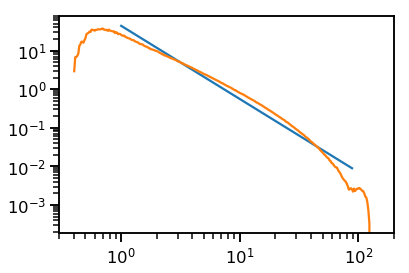

In [29]:
#plt.plot(rm.tpcf_dict['r'], rm.tpcf_dict['tpcf'])
plt.loglog(rm.tpcf_dict['r'][threshold], fitting_xi(rm.tpcf_dict['r'][threshold], *popt_xi))
plt.loglog(rm.tpcf_dict['r'], rm.tpcf_dict['tpcf'])


4.531258842956845


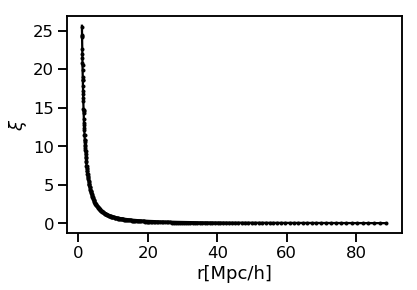

In [30]:
idx = 3

_, chi, popt_xi = param.plot(fitting_xi, rm.tpcf_dict['r'][threshold], rm.tpcf_dict['tpcf'][threshold], 
        'black', 'Halos',parameters[idx], limit = 0)

#plt.text(10,15,r'$c_t(r) = A r^B + C$')

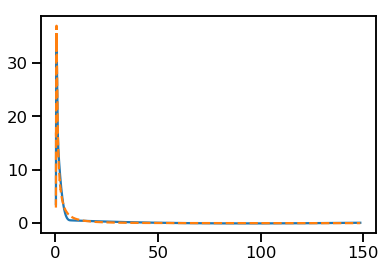

In [31]:
# Compare analytical derivative to interpolated one
from scipy.interpolate import UnivariateSpline

spl = UnivariateSpline(rm.tpcf_dict['r'], rm.tpcf_dict['tpcf']) 

plt.plot(rm.tpcf_dict['r'], spl(rm.tpcf_dict['r']))
plt.plot(rm.tpcf_dict['r'], rm.tpcf_dict['tpcf'], linestyle='dashed')

(0, 50)

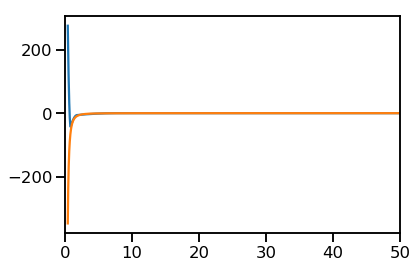

In [32]:
plt.plot(rm.tpcf_dict['r'], spl.derivative()(rm.tpcf_dict['r']))
plt.plot(rm.tpcf_dict['r'], first_xi_dot(rm.tpcf_dict['r'], popt_xi))
plt.xlim(0, 50)

## GENERATE GAUSSIAN STREAMING MODEL WITH FITTED MOMENTS

In [33]:

moments_reduced = np.zeros((len(rm.r_perp), len(rm.r_parallel), 3))


for i, rper in enumerate(rm.r_perp):                                                                                                   
    for j, rpar in enumerate(rm.r_parallel):                                                                                           

        r_ = np.sqrt(rper**2 + rpar**2)                                                                                             
        mu_value = rpar/r_                                                                                                                


        moments_reduced[i,j, 0] = fitting_m_r(r_, *popt_m_r) * mu_value                                                                                  

        moments_reduced[i,j, 1] = fitting_c(r_, *popt_c_r) * mu_value**2 \
                            + fitting_c(r_, *popt_c_t) * (1 - mu_value**2) 



In [34]:
gaussian_reduced = moments2model.Model(rm, moments_reduced, model = 'gaussian')

In [35]:
gaussian_reduced.multipoles(s, mu) 

In [36]:
measured = moments2model.Model(rm, moments_projected, 'measured')

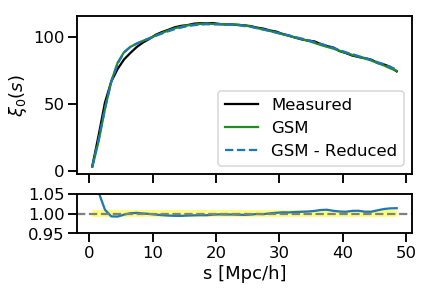

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.mono,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono,
        color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono,
        label = 'GSM - Reduced', linestyle='dashed')

#ax1.plot(gaussian_reduced.s_c, 
#         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced_2.mono,
#        label = 'GSM - Constant Sigma', linestyle='dotted')

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.mono[1:]/gaussian.mono[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax1.legend()


Text(0.5,0,'s [Mpc/h]')

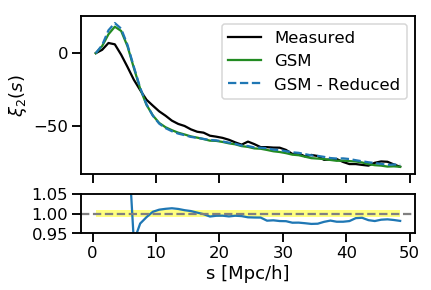

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.quad,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.quad,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad,
                label = 'GSM - Reduced', linestyle='dashed')

#ax1.plot(gaussian_reduced.s_c, 
#         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced_2.quad,
#        label = 'GSM - Constant Sigma', linestyle='dotted')
ax1.legend()
ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.quad[1:]/gaussian.quad[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

Text(0.5,0,'s [Mpc/h]')

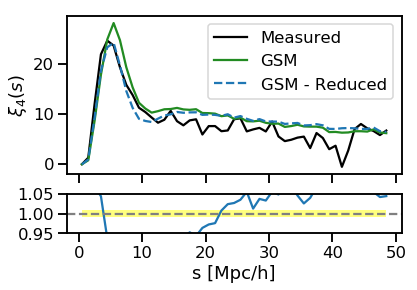

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.hexa,
        color = 'black', label = 'Measured')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.hexa,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa,
                label = 'GSM - Reduced', linestyle='dashed')

#ax1.plot(gaussian_reduced.s_c, 
#         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced_2.hexa,
#        label = 'GSM - Constant Sigma', linestyle='dotted')
ax1.legend(bbox_to_anchor=(1,1))

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.hexa[1:]/gaussian.hexa[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

## TAYLOR EXPANSION

In [40]:
def first_mu_prime(s, mu):
    return (1 - mu**2)/s


def first_m1_dot(s, popt_m_r):
    a, b, c = popt_m_r
    return 0.5 * a/np.sqrt(s) + b

def first_m1_prime(s, mu, popt_m_r):
    
    return first_mu_prime(s,mu) * fitting_m_r(s, *popt_m_r) + \
            mu**2 * first_m1_dot(s, popt_m_r)

In [41]:
def second_mu_prime(s, mu):
    return -3 * (1-mu**2)*mu/s**2
    
def second_s_prime(s,mu):
    return (1 - mu**2)/s

def second_m1_dot(s, popt_m_r):
    a, b, c = popt_m_r
    return -1./4.* a * s**(-3./2.)

def second_m1_prime(s, mu, popt_m_r):
    return second_mu_prime(s, mu) * fitting_m_r(s, *popt_m_r)  + \
            2 * first_mu_prime(s, mu) * mu * first_m1_dot(s, popt_m_r) + \
            mu * (second_s_prime(s, mu) * first_m1_dot(s, popt_m_r) + \
                  mu**2 * second_m1_dot(s, popt_m_r))




In [90]:
def m2(s, mu, popt_m_r, popt_c_r, popt_c_t):
    
    return mu**2 * fitting_c(s, *popt_c_r) + (1-mu**2) * fitting_c(s, *popt_c_t) +\
            mu **2 *fitting_m_r(s, *popt_m_r)**2
      
def first_dot_c(s, popt_c):
    a, b, c = popt_c    
    return a * b * s **(b-1)

    
def second_dot_c(s, popt_c):
    a, b, c = popt_c    
    return a * b * (b-1) * s **(b-2)

def first_c2_prime(s, mu, popt_c_r, popt_c_t):
    
    return (fitting_c(s, *popt_c_r) - fitting_c(s, *popt_c_t)) * 2 * mu * first_mu_prime(s, mu) + \
            mu**3 * first_dot_c(s, popt_c_r) + mu * (1 - mu**2) * first_dot_c(s, popt_c_t)

def second_c2_prime(s, mu, popt_c_r, popt_c_t):
    
    return (fitting_c(s, *popt_c_r) - fitting_c(s, *popt_c_t))* (2 * first_mu_prime(s, mu)**2 \
                                                                 + 2 * mu *second_mu_prime(s,mu)) + \
            (first_dot_c(s, popt_c_r) - first_dot_c(s, popt_c_t)) * 4 *mu**2 * first_mu_prime(s, mu) + \
            mu**2 * (second_s_prime(s,mu) *first_dot_c(s, popt_c_r) + mu**2 * second_dot_c(s, popt_c_r) ) +\
            (1-mu**2) * (second_s_prime(s,mu) *first_dot_c(s, popt_c_t) + mu**2 * second_dot_c(s, popt_c_t) )
            


In [91]:
def first_m2_prime(s, mu, popt_m_r, popt_c_r, popt_c_t):
    
    return first_c2_prime(s, mu, popt_c_r, popt_c_t) + \
            2 * mu * fitting_m_r(s, *popt_m_r) *  first_m1_prime(s, mu, popt_m_r)


def second_m2_prime(s, mu, popt_m_r, popt_c_r, popt_c_t):
    
    return second_c2_prime(s, mu, popt_c_r, popt_c_t) + \
            2 * first_m1_prime(s, mu, popt_m_r)**2 + \
            2 * mu * fitting_m_r(s, *popt_m_r) * second_m1_prime(s, mu, popt_m_r)

In [92]:
def first_xi_dot(s, popt_xi):
    a, b = popt_xi
    
    return - b * (s/a)**(-b) / s
    
def second_xi_dot(s, popt_xi):
    a, b = popt_xi
    
    return b * (b + 1) * (s/a)**(-b)/s**2

def first_xi_prime(s, mu, popt_xi):
    return mu * first_xi_dot(s, popt_xi)

def second_xi_prime(s, mu, popt_xi):
    return second_s_prime(s,mu) * first_xi_dot(s, popt_xi)  + \
            mu**2 * second_xi_dot(s, popt_xi)

In [93]:
def legendre(mu, multipole_order):
    
    if multipole_order == 0:
        return 1
    
    elif multipole_order == 2:
        return 1./2. * (3 * mu**2 - 1)
    
    elif multipole_order == 4:
        return 1./8. * (35 *mu**4 - 30 *  mu**2 + 3)
    
    else:    
        raise ValueError('Multipole order not implemented.')    
    
def s_mu_approximation(mu, s, order, derivatives):
    
    tpcf = interp1d(rm.tpcf_dict['r'], rm.tpcf_dict['tpcf'],
                       kind = 'linear', bounds_error = False,
                        fill_value = (rm.tpcf_dict['tpcf'][0], 0.))

    if not derivatives:
        
        approx = tpcf(s) -first_m1_prime(s, mu, popt_m_r)

        if order == 2:
            approx +=  0.5 * second_m2_prime(s, mu, popt_m_r,
                                             popt_c_r, popt_c_t)
            
    else:
        
        approx = (1. + tpcf(s)) * (1. - first_m1_prime(s, mu, popt_m_r)) \
                - first_xi_prime(s, mu, popt_xi) * mu * fitting_m_r(s, *popt_m_r)\
                - 1.

        if order == 2:
            
            approx = (1. + tpcf(s)) * ( 1. - first_m1_prime(s, mu, popt_m_r) + \
                0.5 * second_m2_prime(s, mu, popt_m_r,
                                    popt_c_r, popt_c_t) ) \
                + first_xi_prime(s, mu, popt_xi) * (- mu * fitting_m_r(s, *popt_m_r) \
                +  first_m2_prime(s, mu, popt_m_r, popt_c_r, popt_c_t)) \
                + 0.5 * second_xi_prime(s, mu, popt_xi) * m2(s, mu, popt_m_r, popt_c_r, popt_c_t)\
                - 1.
        
        
    return approx


def multipoles_approximation(mu, s, order, multipole_order, derivatives):
    
     return (2 * multipole_order + 1)/2. * \
                s_mu_approximation(mu, s, order, derivatives) * legendre(mu, multipole_order)

In [94]:
def approximation(order, derivatives = False):
    
    x = sym.Symbol('x')

    s_c = 0.5* (s[1:] + s[:-1])
    
    mono_approx = np.zeros((len(s_c)))
    quad_approx = np.zeros((len(s_c)))
    hexa_approx = np.zeros((len(s_c)))

    for i, s_value in enumerate(s_c):
        mono_approx[i] = sym.integrate(multipoles_approximation(x, s_value, order, 0, derivatives),
                                       (x, -1, 1))
        quad_approx[i] = sym.integrate(multipoles_approximation(x, s_value, order, 2, derivatives),
                                       (x, -1, 1))
        hexa_approx[i] = sym.integrate(multipoles_approximation(x, s_value, order, 4, derivatives),
                                       (x, -1, 1))

    return mono_approx, quad_approx, hexa_approx


In [95]:
mono_1, quad_1, hexa_1 = approximation(1)
mono_2, quad_2, hexa_2 = approximation(2)

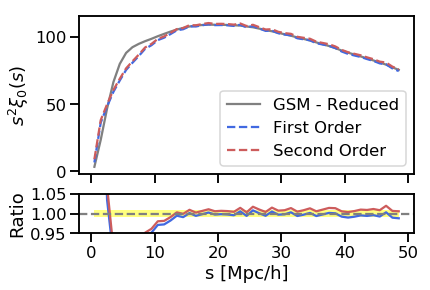

In [96]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         mono_1[1:]/gaussian_reduced.mono[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
         mono_2[1:]/gaussian_reduced.mono[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()

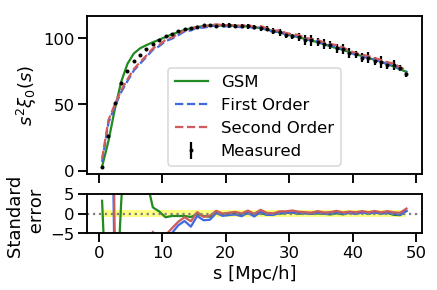

In [97]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.mono.mean,
            yerr =  rm.s_c * rm.s_c * rm.mono.std,
            color = 'black', linestyle='',
             label = 'Measured', marker='o',
             markersize=3)

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian.mono, 
         label = 'GSM', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian.s_c, (gaussian.mono - rm.mono.mean)/rm.mono.std,
        color = 'forestgreen')

ax2.plot(gaussian.s_c, (mono_1 - rm.mono.mean)/rm.mono.std,
        color = 'royalblue')


ax2.plot(gaussian.s_c, (mono_2 - rm.mono.mean)/rm.mono.std,
        color = 'indianred')




ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')


ax2.axhline(y = 0., color='gray', linestyle='dotted')
ax2.fill_between(gaussian_reduced.s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)
ax2.set_ylabel("Standard \n error")


ax1.legend()

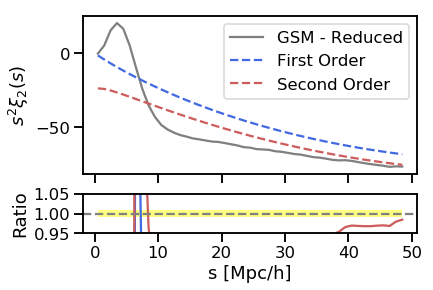

In [98]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         quad_1[1:]/gaussian_reduced.quad[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
        quad_2[1:]/gaussian_reduced.quad[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()

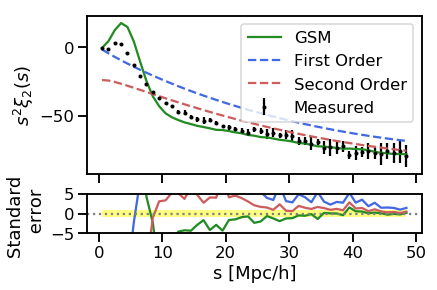

In [99]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.quad.mean,
            yerr =  rm.s_c * rm.s_c * rm.quad.std,
            color = 'black', linestyle='',
             label = 'Measured', marker='o',
             markersize=3)

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian.quad, 
         label = 'GSM', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian.s_c, (gaussian.quad - rm.quad.mean)/rm.quad.std,
        color = 'forestgreen')

ax2.plot(gaussian.s_c, (quad_1 - rm.quad.mean)/rm.quad.std,
        color = 'royalblue')


ax2.plot(gaussian.s_c, (quad_2 - rm.quad.mean)/rm.quad.std,
        color = 'indianred')




ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

ax2.set_ylabel("Standard \n error")

ax2.axhline(y = 0., color='gray', linestyle='dotted')
ax2.fill_between(gaussian_reduced.s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)

ax1.legend()

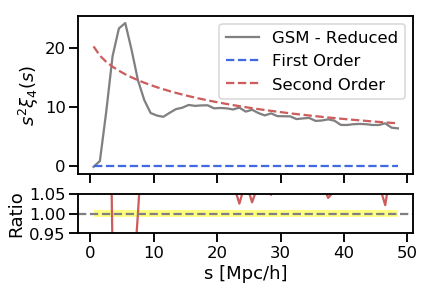

In [100]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         hexa_1[1:]/gaussian_reduced.hexa[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
        hexa_2[1:]/gaussian_reduced.hexa[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax2.set_ylabel(r'Ratio')

ax1.legend()

Text(0,0.5,'Standard \n error')

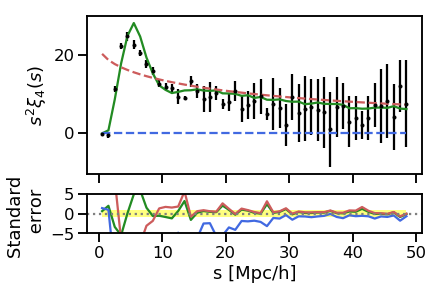

In [101]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})


ax1.errorbar(rm.s_c, rm.s_c * rm.s_c * rm.hexa.mean,
            yerr =  rm.s_c * rm.s_c * rm.hexa.std,
            color = 'black', linestyle='',
             label = 'Measured', marker='o',
             markersize=3)

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian.hexa, 
         label = 'GSM', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian.s_c, (gaussian.hexa - rm.hexa.mean)/rm.hexa.std,
        color = 'forestgreen')

ax2.plot(gaussian.s_c, (hexa_1 - rm.hexa.mean)/rm.hexa.std,
        color = 'royalblue')

ax2.plot(gaussian.s_c, (hexa_2 - rm.hexa.mean)/rm.hexa.std,
        color = 'indianred', linestyle='-')




ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')


ax2.axhline(y = 0., color='gray', linestyle='dotted')
ax2.fill_between(gaussian_reduced.s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)
ax2.set_ylabel("Standard \n error")

#ax1.legend(bbox_to_anchor = (1,1))

## Including \xi derivatives

In [102]:
mono_1_derivatives, quad_1_derivatives, hexa_1_derivatives = approximation(1, derivatives = True)
mono_2_derivatives, quad_2_derivatives, hexa_2_derivatives = approximation(2, derivatives = True)

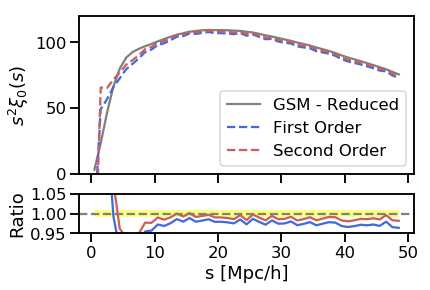

In [103]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1_derivatives, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2_derivatives,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         mono_1_derivatives[1:]/gaussian_reduced.mono[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
         mono_2_derivatives[1:]/gaussian_reduced.mono[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax1.set_ylim(0.,120)

ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()

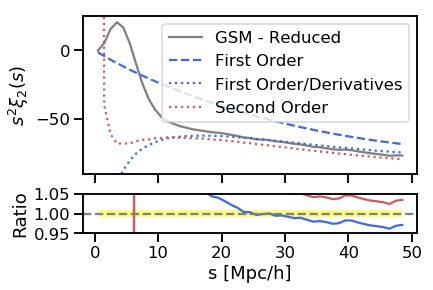

In [104]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1_derivatives, 
         label = 'First Order/Derivatives', linestyle='dotted', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2_derivatives,
         label = 'Second Order', linestyle='dotted', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         quad_1_derivatives[1:]/gaussian_reduced.quad[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
        quad_2_derivatives[1:]/gaussian_reduced.quad[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax1.set_ylim(-90,25)
ax1.legend()

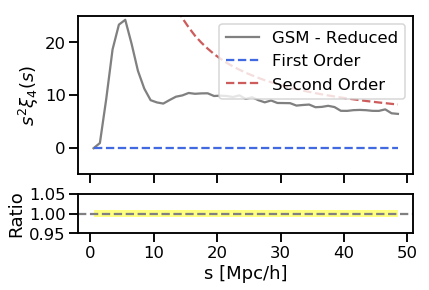

In [105]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa, 
         label = 'GSM - Reduced', color='gray')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1_derivatives, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2_derivatives,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         hexa_1_derivatives[1:]/gaussian_reduced.hexa[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
        hexa_2_derivatives[1:]/gaussian_reduced.hexa[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax2.set_ylabel(r'Ratio')
ax1.set_ylim(-5,25)

ax1.legend()

In [122]:
import importlib
importlib.reload(tt)

<module 'taylor_tools' from '/cosma/home/dp004/dc-cues1/CentralStreamingModel/dimred/taylor_tools.py'>

In [131]:
mono_derivat, quad_derivat, hexa_derivat = tt.approximation(s, 2,
                popt_xi, popt_m_r, popt_c_r, popt_c_t, 
                rm.tpcf_dict, derivatives = False)

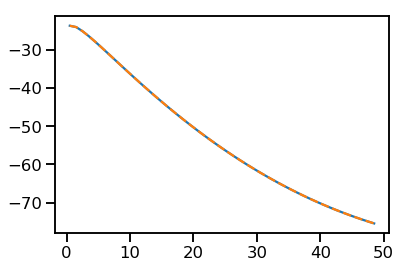

In [132]:
plt.plot(gaussian.s_c, gaussian.s_c**2 * quad_derivat)
plt.plot(gaussian.s_c, gaussian.s_c**2 * quad_2, linestyle='dashed')
